<h1> SGWB Figure of Merits</h1> 

In the following, we'll implement a notebook that, given the required Probability Distribution Functions (PDF) describing a Black Hole population(BH), generates the figure of merit for the predicted analytical Stochastic Gravitational Wave Background(SGWB) in function of the amplitude and redshift range of the merging rate.
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import pandas as pd
import multiprocessing as mp
import scipy.stats as scst
from scipy import interpolate
from scipy.integrate import quad
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from multiprocessing import Pool, Manager, Value
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
#%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Flags for the execution modes, initialized to false, check the the FLAG selection section for additional informations and initializing them !

# Flag needed to simulate the standard LIGO SOBBH population

SOBBH = False
SOBBH_Redevol = False
SOBBH_RSpike = False

# Flags for different types of PBH mass distribution

PBH = False
PBH_fRz = False
PBH_LogNormal = False
PBH_Gaussian = False

# Merger distribution parameters

T_obs = 6. # Lisa estimated years of observation
efficiency = 0.75 # Lisa effective usefull time percentage for observations
max_tc = 10000. # max years of coalescence time for a BBH mergine event
frq_min = 3.e-5
frq_max = 0.5 # Maximum frequency in hertz to which the LISA detector is sensitive
frq_star = 1.e-2 # Value of the choosen frequency at which we estimate the SGWB to compare with other results

# The total time used to generate the merging events by multipling for the rate of merging will be set to max_tc


#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
GPc = 3.08567758149137*1e25 # meters
h = 0.678
H_0 = 67.8/(3.086e+19) # Hubble constant in 1/(s)
Omega_m = 0.3 # Matter density in our universe
Omega_lambda = 0.7 # Cosmological constant density in our universe
Omega_k = 0. # Curvature density in our universe
rho_c = (3.*(H_0**2.))/(8.*np.pi*G) # Critical density in our universe
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

n_jobs = 10
frq_res = 1e-6
frq_prec = int((frq_max - frq_min)/frq_res) + 1


<h2> FLAG selection section </h2>

To begin, we have to decide which types of sources we wish to simulate in our SGWB, in order to use the standard _LIGO-Virgo_ fiducial mass function we have to set the _SOBBH_ flag on :

In [3]:
#SOBBH = True # If true, add the total SGWB strain produced by stellar origin binary black hole merging on the strain as estimated by LIGO

if we wish to simulate PBH perturbations, instead, we have to choose between the two following different mass functions :

In [4]:
PBH = True # If true, the FOM will be generated considering a PBH perturbation to the fiducial model

In [5]:
#PBH_LogNormal = True# This will simulate the Log Normal mass distribution for PBH described in ariv 2109.05836
PBH_Gaussian = True # This will simulate a Gaussian PBH mass distribution, that can be used to generalize a bit the standard monocromatic mass function for PBH

We may also decide to simulate the catalogue with a redshift evolving merging rate, by setting to true the Red_evol flag:

In [6]:
#SOBBH_Redevol = True # If true, the merging rate will evolve as a function of redshift, if false it will be assumed constant over the volume
#SOBBH_RSpike = True # If true, generate a spike of merging rate in a small redshift region, the population will follow the standard SOBBH one

in the case of PBH, instead, we are gonna generate the merging rate following a simple power law with $k = 1.4$ [cite arxiv 2201.12218], for what concern the value of $R_0$, we will consider it to be a certain fraction $f$ of the original _SOBBH_ merging rate. This mode can be run by activating the flag _PBH_fRz_:

In [7]:
PBH_fRz = True # If true, the merging rate would assumed to be the simple power law evolution of a fixed k, where the 

Given the sources, we can furthermore decide if we wish to plot their merging rates in function of $z$ :

In [8]:
Plot_Rz = True

<h2> Utility functions </h2>

In the following, we are going to define some useful generical functions that will be needed to present the results.
We will start with a function that can be used to convert matplotlib contour line to arrays.

In [9]:
def get_contour_verts(cn):
    # Given a set of contour line, save them as a dictionary
    contours = []
    # for each contour line
    for cc in cn.collections:
        paths = []
        # for each separate section of the contour line
        for pp in cc.get_paths():
            xy = []
            # for each segment of that section
            for vv in pp.iter_segments():
                xy.append(vv[0])
            paths.append(np.vstack(xy))
        contours.append(paths)

    return contours

<h2> Standard Cosmological Functions </h2>

First of all, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [10]:
# Just a function to convert from Z to GPC using Hubble Law, in order to obtain the comoving distance

z_max = 1.e5
z_prec = 500

def H(z):
    return np.sqrt((H_0**2.)*(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))

def Z_to_Gpc(z):
    
    # Remove the commented part to use a linear approximation of the Hubble law for low z 
    
    #if(zmax <= 0.5):
    #    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 0.5
    #else:
        
        Int_Z = 0.
        span_z = np.linspace(0.,z,z_prec)
        
        # Beware, would fail if the span z is created in logarithmic scale !
        
        for i in range(len(span_z) -1):
            mid_z = 0.5*(span_z[i] + span_z[i + 1])
            Int_Z += (((span_z[i + 1] -  span_z[i])*c*(10**(-3)))/(H(mid_z)*(3.086e+19)))
    
        return Int_Z
    
def Z_to_HubbleTime(z):
    
    Int_Z = 0.
    span_z = np.logspace(np.log10(z),np.log10(z_max),z_prec)
        
    # Beware, would fail if the span z is created in logarithmic scale !
        
    for i in range(len(span_z) -1):
        mid_z = 0.5*(span_z[i] + span_z[i + 1])
        Int_Z += (span_z[i + 1] -  span_z[i])/(H(mid_z)*(1. + mid_z))
    
    return Int_Z
    
        

we also need a function that estimates the differential comoving volume in function of the redshift :

In [11]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z, Delta_z):
    r = Z_to_Gpc(z)
    z_2 = z + 0.5*Delta_z
    z_1 = z_2 - Delta_z
    Delta_r = Z_to_Gpc(z_2) - Z_to_Gpc(z_1)
    return ((4.*np.pi*(r**2.)*Delta_r)/Delta_z)

Another recurring parameter for inspiralling events is the Chirp Mass, given the mass of the two events involved in the binary merging :

In [12]:
# Function that return the Chirp Mass of a binary merging event

def ChirpMass(m1,m2): 
   return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))

together with the effective spin :

In [13]:
#Function that given the spin and spin tilt gives the effective spin

def EffectiveSpin(m1, m2, a1, a2, st_a1, st_a2):
    res = (m1*a1*cos(st_a1))/(m1 + m2) + (m2*a2*cos(st_a1))/(m1 + m2) # Hope so, better to double check

To represent the signal in units of omega, we are gonna need to convert our strain from units of _h_, _hc_, or _Flux_ to units of $\Omega_{gw}$ :

In [14]:
def h_to_Omega(ran_frq, spectrum):
    # ran_frq and spectrum need to have same shape
    return ((4*((h*np.pi)**2.)*(ran_frq**3.)*spectrum)/(3.*(H_0**2)))

In [15]:
def hc_to_Omega(ran_frq, spectrum):
    # ran_frq and spectrum need to have same shape
    return ((2*((h*np.pi)**2.)*(ran_frq**2.)*spectrum)/(3.*(H_0**2)))

In [16]:
def Flux_to_Omega(ran_frq, Flux):
    # Flux need to be a constant expressing the whole integrated flux in function of z and m
    return ((ran_frq**(2./3.))/(rho_c*(c*1e3)**3))*Flux

To conclude, we may define the energy loss during the inspiral phase, the procedure implemented is described in [P. Ajith et al.](https://arxiv.org/abs/0909.2867), even though in the LISA case we can use the assumption that all the waveforms appearing in detector, are in the pre-merger phase.
We have :

In [17]:
def dE_dnu(m1, m2, freq, a1 = -1, a2 =-1, st_a1 = -1, st_a2 = -1):
    # Compute the energy dispersed during an inspiral phase to a certain post-newtonian order in the pre-merger approximation
    # If the 4 parameters describing the spin configuration are not given, would automatically use only the first post-newtonian term
    
    Ch_M = ChirpMass(m1,m2)
    eta = m1*m2/(Ch_M**2)
    nu_prime = (np.pi*Ch_M*sol_mass*G*freq/c**3)**(1./3.)
    
    alpha_2 = -(323/224) + (451/168)*eta
    if(a1 == -1 or a2 == -1 or st_a1 == -1 or st_a2 == -1):
        alpha_3 = 0
    else:
        chi_spin = EffectiveSpin(m1, m2, a1, a2, st_a1, st_a2) 
        alpha_3 = ((27/8) - (11/6)*eta)*chi_spin
    f1 = 1 + alpha_2*nu_prime**2 + alpha_3*nu_prime**3
    
    res = (((G*np.pi)*(Ch_M**(5./3.)))/3)*(freq**(-1./3.))*(f1**2)
    
    return res
    

while the total spectrum in Omega given by any BH channel expressed in energy spectral density, can be generally described using :

In [18]:
def SpectralDens_to_OmegaGW(freq, F_nu):
    res = (freq/(rho_c * c**3))*F_nu

<h2> LISA sensitivity curve </h2>

In the following we are going to generate the LISA sensitivity curve, in order to compare our result with the properties of the instrument.
The shape of the sensitivity curve in units of S can be defined using the following function :

In [19]:
# return the value of the sensitivity curve S_h given the frequency

def get_SciRD(freq):
    S_2 = 3.6*10.**(-41.) #1/Hz
    S_1 = 5.76*(1. + (0.0004/freq)**2.)*10.**(-48.) # 1/(Hz*s^4)
    S_R = 1. + (freq/0.025)**2.
    S_h = (10./3.)*S_R*((S_1/(2.*np.pi*freq)**4.) + S_2)
    return S_h

<h2> SOBBH LIGO All Channels SGWB </h2>

In this section, we are going to initialize all the objects needed to compute the Stellar Origin Binary Black Hole merging(SOBBHm) SGWB.
The probability distribution implemented for the variables of the events, will be taken from [B. P. Abbott T1](https://arxiv.org/abs/1811.12940), [B. P. Abbott T2](https://arxiv.org/abs/2010.14533).

<h3> SOBBH - Characteristic strain functions </h3>

The characteristic strain is given by :

In [20]:
# Function to estimate the characteristic strain for SOBBHm events

def SOBBH_hcsqrd(frq, SOBBH_IntFac):
    return ((4.*G**(5./3.))/(3.*(np.pi**(1./3.))*(c*10**3)**2))*(frq**(-4./3.))*SOBBH_IntFac
            

<h3> SOBBH - Mass distribution functions </h3>

Let's start by defining the probability distribution in function of the masses.

We have :

In [21]:
# Power law + Peak Mass Model of the paper arxiv 2010.14533

if SOBBH :
        
    # Mass Distribution parameters (values taken from the results of arxiv 2111.03634)

    m_min = 2.5 # + 0.67 - 0.44  minimum mass allowed by the popolation inference 
    m_max = 100. # Solar Masses, taken from the prior of the paper as no real higher mass cutoff was estimated !
    SOBBH_massprec = 600 # Binning density for the masses
    alpha = 3.4 # + 0.58 - 0.49 Power law index
    beta_q = 1.1 # + 1.8 - 1.3  index for m2 power law in q
    delta_m = 7.8 #+ 1.9 - 4.0  used for the low mass smoothing function, generate peak at delta_m + m_min
    lambda_peak = 0.039 # + 0.058 - 0.026 Intensity of the gaussian peak
    mu_m = 34 # + 2.3 - 3.8 Location of the Gaussian peak in Solar Masses
    sigma_m = 5.09 # +4.28 - 4.34 Solar Masses, taken from arxiv 2010.14533 as no additional claim was made on last paper

    # Defining of the smoothing function for m close to the minimimum mass

    def SOBBH_MassSmoothing(m, SOBBH_m, SOBBH_deltam):
        if(m < SOBBH_m):
            return 0.
        else:
            if(m >= (SOBBH_m + SOBBH_deltam)):
                return 1.
            else:
                factor = np.exp((SOBBH_deltam/(m - SOBBH_m)) + (SOBBH_deltam/(m - SOBBH_m - SOBBH_deltam)))
                return 1./(factor + 1.)

    # Defining a normalized power law distribution function, needed for the final distribution function        

    def SOBBH_MassPowLaw(m, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm):
        if(SOBBH_m < m < SOBBH_M):
            return (1./SOBBH_PLnorm)*(m**(-SOBBH_alpha))
        else:
            return 0.

    # Estimating the Phase space of the Power law distribution using trapezoidal integration

    def SOBBH_PowerLawPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_alpha):

        ris = 0.

        for i in range(len(SOBBH_ranm1)- 1):
           if(SOBBH_ranm1[i] >= SOBBH_m and SOBBH_ranm1[i] <= SOBBH_M):
                    mid_m1 = 0.5*(SOBBH_ranm1[i + 1] + SOBBH_ranm1[i])
                    ris +=  (SOBBH_ranm1[i + 1] - SOBBH_ranm1[i])*(np.power(mid_m1, (-SOBBH_alpha)))

        return ris


    # Defining a Gaussian distribution of the mass, needed for the final distribution function

    def SOBBH_MassGauss(m, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm):
        return ((1./(SOBBH_sigmam*np.sqrt(2.*np.pi)))*np.exp(-0.5*((m-SOBBH_mum)/SOBBH_sigmam)**2.))*1./SOBBH_GSnorm

    def SOBBH_GaussPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_mum, SOBBH_sigmam):

        ris = 0.

        for i in range(len(SOBBH_ranm1)- 1):
           if(SOBBH_ranm1[i] >= SOBBH_m and SOBBH_ranm1[i] <= SOBBH_M):
                    mid_m1 = 0.5*(SOBBH_ranm1[i + 1] + SOBBH_ranm1[i])
                    ris +=  (SOBBH_ranm1[i + 1] - SOBBH_ranm1[i])*((1./(SOBBH_sigmam*np.sqrt(2.*np.pi)))\
                            *np.exp(-0.5*((mid_m1-SOBBH_mum)/SOBBH_sigmam)**2.))

        return ris


    # Defining the normalization constant for the q dependancy of the total mass distribution

    def SOBBH_P2PS(SOBBH_ranm2, SOBBH_betaq, SOBBH_m, SOBBH_deltam):

        q_norm = np.linspace(0,1,len(SOBBH_ranm2))

        for i in range(len(SOBBH_ranm1) - 1):

            q_norm[i] = 0.

            for j in range(i + 1):

                q_norm[i] += ((0.5*(SOBBH_ranm2[j] + SOBBH_ranm2[j + 1])/(0.5*(SOBBH_ranm2[i] + SOBBH_ranm2[i + 1])))\
                             **(SOBBH_betaq))*(SOBBH_ranm2[j + 1] - SOBBH_ranm2[j])*\
                             SOBBH_MassSmoothing(0.5*(SOBBH_ranm2[j] + SOBBH_ranm2[j + 1]), SOBBH_m, SOBBH_deltam)

        q_norm[len(SOBBH_ranm1) - 1] = q_norm[len(SOBBH_ranm1) - 2]

        return q_norm   


    # Defining the proper Mass distribution function

    def SOBBH_MassDistr(m1, m2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, SOBBH_MassPS):

        if(m1 > m2):
            return ((1. - SOBBH_lambdapeak)*SOBBH_MassPowLaw(m1, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm) + \
                    SOBBH_lambdapeak*SOBBH_MassGauss(m1, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm))*\
                    SOBBH_MassSmoothing(m1, SOBBH_m, SOBBH_deltam)*\
                    ((m2/m1)**(SOBBH_betaq))*(1./SOBBH_qnorm)*\
                    SOBBH_MassSmoothing(m2, SOBBH_m, SOBBH_deltam)*(1./SOBBH_MassPS)
        else:
            return 0.


    # Estimating the Phase space for the Model C Mass distribution function using trapezoidal integration

    def SOBBH_ModCPS(SOBBH_ranm1, SOBBH_ranm2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, SOBBH_MassPS):

        ris = 0.

        for i in range(len(SOBBH_ranm1)- 1):
            for j in range(len(SOBBH_ranm2)- 1):
                 if(SOBBH_ranm1[i] >= SOBBH_ranm2[j]):
                    mid_m1 = 0.5*(SOBBH_ranm1[i + 1] + SOBBH_ranm1[i])
                    mid_m2 = 0.5*(SOBBH_ranm2[j + 1] + SOBBH_ranm2[j])
                    q = mid_m2/mid_m1 
                    ris +=  (SOBBH_ranm1[i + 1] - SOBBH_ranm1[i])*(SOBBH_ranm2[j + 1] - SOBBH_ranm2[j])*\
                    ((1. - SOBBH_lambdapeak)*SOBBH_MassPowLaw(mid_m1, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_PLnorm)\
                    + SOBBH_lambdapeak*SOBBH_MassGauss(mid_m1, SOBBH_mum, SOBBH_sigmam, SOBBH_GSnorm))\
                    *SOBBH_MassSmoothing(mid_m1, SOBBH_m, SOBBH_deltam)*(q**(SOBBH_betaq))\
                    *(1./SOBBH_qnorm[i])*SOBBH_MassSmoothing(mid_m2, SOBBH_m, SOBBH_deltam)*(1./SOBBH_MassPS)

        return ris
    

<h3> SOBBH - Redshift dependent statistic </h3>

We may now define, the various implemented merging rates as a function of the redshift _z_ as :

In [22]:
# Constant merging rate throughout the volume as fitted in the paper arxiv 1811.12940

#def R(z):
#    return 53.2 # +58.5 - 27.0 Gpc^-3 yr-1 Merger rate density assumed constant over the comoving volume

In [23]:
# Function for the merging rate as described in the paper arxiv 2010.14533, the flag Red_evol will decide if adopting a merging rate the evolve with redshift (true) or not (false)

if SOBBH :
    
    SOBBH_z = 1.e-5 # to avoid SNR divergence due to extremely close events
    SOBBH_Zlog = 0.1 # max z value generated in log scale
    SOBBH_Zlin = 10.0 # max z value generated in lin scale
    SOBBH_zprec = 600 # Binning density for the redshift

    SOBBH_k = 2.7 # + 1.8 - 1.9  VALID FOR REDSHIFT EVOLVING POWER LAW + PEAK MODEL MASS DISTRIBUTION, total agreement with SFR
    SOBBH_CorrRz = (((1. + 0.2)**SOBBH_k)/(1. + ((1. + 0.2)/2.9)**(SOBBH_k + 2.9)))**(-1) # Normalization factor estimated at z = 0.2
    
    # Defining the value of R0, the 0 index will have the value for redshift evolution merging rate, the 1 index would have the one for constant merging rate

    SOBBH_R0 = {}
    SOBBH_R0[0] = 28.1/(year*GPc**3.)# +14.8 - 10.0 GPC⁻³ yr^⁻¹ Value of the merging rate fitted at z = 0.2
    SOBBH_R0[1] = 23.9/(year*GPc**3.) # +14.9 - 8.6 m^-3 s^-1 Middle value fitted using a Power Law + Peak mass model and a non evolving merging rate

    def SOBBH_R(z):
        if(SOBBH_Redevol):
            # This merging rate was interpolated by Angelo Ricciardone and Daniel Figueroa based on arxiv 2010.14533 and arxiv 1907.12562
            return SOBBH_R0[0]*SOBBH_CorrRz*((1. + z)**SOBBH_k)/(1. + ((1. + z)/2.9)**(SOBBH_k + 2.9))
        else:
            return SOBBH_R0[1]

# If we wish to generate just a spike of events at a certain redshift range coming from a merging rate with fixed amplitude, we fix the following        
        
if SOBBH_RSpike:
    # These variables would set the location of the spike in the redshift range
    SOBBH_Rzmin = 2.
    SOBBH_Rzmax = 10.
    SOBBH_zprec = 80
    # These variables, will set the phase space to span in order to obtain the figure of merit 
    SOBBH_SpikeAmplMin = 0.
    SOBBH_SpikeAmplMax = 10000.
    SOBBH_SpikeAmplPrec = 500
    # This will be the value of the amplitude of the merging rate for the constant spike
    SOBBH_SpikeAmpl = 1.
    
    def SOBBH_R(z):
        # Pass the amplitude in units of 1/[yr*GPc], tipically the value is between [1, 200]
        return SOBBH_SpikeAmpl/(year*(GPc**3.))


<h3> SOBBH - Number density of events</h3>

We may finally define the distribution function for the number of events,in particular let's start with the function that describes the merging rate dependancy on the reference frame time: 

In [24]:
def DtrDz(z):
    ris = 1./(H_0*(1. + z)*np.sqrt(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))
    return ris
        

we can now integrate the mass and redshift dependant factor in order to get a constant that will multiply the frequency dependance of the characteristic strain function.
After putting together all the integral dependant factors, we just have to integrate :

In [25]:
if SOBBH :
    def SOBBH_IntND(i):
        
        ris = 0.
        
        if ((i*10)%len(SOBBH_ranz) == 0) :
            print('Percentage of completition : ',(i*100.)/(len(SOBBH_ranz)), '%')
                
        for j in range(len(SOBBH_ranm1)-1):
            for k in range(j + 1):
                deltas = (SOBBH_ranz[i + 1] - SOBBH_ranz[i])*(SOBBH_ranm1[j + 1] - SOBBH_ranm1[j])*(SOBBH_ranm2[k + 1] - SOBBH_ranm2[k])
                ris += deltas*SOBBH_R(0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]))*\
                            SOBBH_MassDistr(0.5*(SOBBH_ranm1[j + 1] + SOBBH_ranm1[j]), 0.5*(SOBBH_ranm2[k + 1] + SOBBH_ranm2[k]),\
                                           SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, \
                                           SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, \
                                           SOBBH_qnorm[j], SOBBH_MassPS)*\
                            DtrDz(0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]))*\
                            ((ChirpMass(0.5*(SOBBH_ranm1[j + 1] + SOBBH_ranm1[j]),\
                                        0.5*(SOBBH_ranm2[k + 1] + SOBBH_ranm2[k]))*sol_mass)**(5./3.))\
                            /((1. + 0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]))**(1./3.)) 
                        
        return [0.5*(SOBBH_ranz[i + 1] + SOBBH_ranz[i]),ris]
                               
                        

<h2> PBH mass functions </h2>

In this section, we are going to initialize the mass functions needed to simulate the _Primordial Black Holes (PBH)_ SGWB.


<h3> PBH - Merging Rates </h3>

In order to compute a PBH perturbation analysis, we are gonna define the PBH merging rate as a fraction of the fiducial LIGO merging rate, evolving with a simple power law having $k = 1.4$. 
The model is as follows :

In [26]:
if PBH_fRz :
    
    PBH_zmin = 3. # minimum value of the PBH merging rate
    PBH_zmax = 10.0 # max z value generated in lin scale
    PBH_zprec = 250 # Binning density for the redshift

    PBH_k = 1.4 # Value taken from arxiv 2201.12218, valid for high z !!
    # Defining the value of R0, the 0 index will have the value for redshift evolution merging rate, the 1 index would have the one for constant merging rate

    PBH_R0 = 28.1/(year*GPc**3.) # +14.8 - 10.0 GPC⁻³ yr^⁻¹ Value of the merging rate fitted in at z = 0.2 in ligo population inference paper arxiv2111.03634
    PBH_CorrfRz = 1./(1. + 0.2)**PBH_k
    
    def PBH_fR(z,f):
        return f*PBH_R0*PBH_CorrfRz*((1. + z)**PBH_k)

<h3> PBH - Gaussian Mass Distribution </h3>

We can define a Gaussian mass distribution for PBH as :

In [27]:
if PBH_Gaussian:
    PBH_m = 0. # Solar Masses. Minimum value assumed for the PBH mass
    PBH_M = 300. # Solar Masses. Maximum value assumed for the PBH mass
    PBH_massprec = 250 # Binning density for the mass range
    PBH_pdfmspan = np.linspace(0., 200., 100) # this span will be needed to compute the figures of merit
    PBH_mu = 5. # mean of the Gaussian distribution
    PBH_sigmam = 50. # sigma of the variance distribution
    
    # We use the following distribution for the mass, this tend to a monochromatic mass function for small values of sigma, yet it can be used to generalize the result to a wider subset of cases
    def PBH_MassGauss(m, PBH_mu, PBH_sigmam, PBH_GSnorm):
        return ((1./(PBH_sigmam*np.sqrt(2.*np.pi)))*np.exp(-0.5*((m-PBH_mu)/PBH_sigmam)**2.))*1./PBH_GSnorm
    
    # This function is to estimate the normalization constant
    def PBH_GaussPS(PBH_ranm1, PBH_m, PBH_M, PBH_mu, PBH_sigmam):

        ris = 0.

        for i in range(len(PBH_ranm1)- 1):
            if(PBH_ranm1[i] >= PBH_m and PBH_ranm1[i] <= PBH_M):
                    mid_m1 = 0.5*(PBH_ranm1[i + 1] + PBH_ranm1[i])
                    ris +=  (PBH_ranm1[i + 1] - PBH_ranm1[i])*PBH_MassGauss(mid_m1, PBH_mu, PBH_sigmam, 1.)
            
        return ris


<h3> PBH - Log-Normal Mass Distribution </h3>

We can define a Log-Normal mass distribution for PBH as described in the paper by [S. S. Bavera et al ](https://arxiv.org/abs/2109.05836):

In [28]:
if PBH_LogNormal:
    # We use the following distribution for the mass
    PBH_m = 3. # Solar Masses. Minimum value assumed for the PBH mass
    PBH_M = 300. # Solar Masses. Maximum value assumed for the PBH mass
    PBH_massprec = 250 # Binning density for the mass range
    PBH_pdfmspan = np.linspace(25, 250, 100) # this span will be needed to compute the figures of merit
    PBH_Mc = 34.54 # Solar masses, taken from the main paper by Bavera
    PBH_sigmamn = 0.41 # Taken from the main paper by Bavera
    
    def PBH_MassLNorm(m, PBH_Mc, PBH_sigmamn, PBH_LNnorm):
        return (1./(np.sqrt(2*np.pi)*PBH_sigmamn*m))*np.exp(-(np.log(m/PBH_Mc)**2)/(2*PBH_sigmamn**2))*1./PBH_LNnorm
    
    # This function is to estimate the normalization constant
    def PBH_LNnormPS(PBH_ranm1, PBH_m, PBH_M, PBH_Mc, PBH_sigmamn):

        ris = 0.

        for i in range(len(PBH_ranm1)- 1):
            if(PBH_ranm1[i] >= PBH_m and PBH_ranm1[i] <= PBH_M):
                    mid_m1 = 0.5*(PBH_ranm1[i + 1] + PBH_ranm1[i])
                    ris +=  (PBH_ranm1[i + 1] - PBH_ranm1[i])*PBH_MassLNorm(mid_m1, PBH_Mc, PBH_sigmamn, 1.)
            
        return ris


<h3> PBH - Number density of events</h3>

As we did for _SOBBH_, we can now integrate the mass and redshift dependant factors for _PBH_ in order to get the constant term that will multiply the frequency dependance of the characteristic strain function for the _SGWB_.
After putting together all the integral dependant factors, we just have to integrate :

In [29]:
if PBH :
    def PBH_IntND(i):
        
        ris = 0.
        
        # Estimating the normalization constant for the Gaussian Case 
        
        if PBH_Gaussian:
            PBH_GSnorm = PBH_GaussPS(PBH_ranm1, PBH_m, PBH_M, 0.5*(PBH_pdfmspan[i + 1] + PBH_pdfmspan[i]), PBH_sigmam)
        
        # Estimating the normalization constant for the LogNormal case
        
        if PBH_LogNormal:
            PBH_LNnorm = PBH_LNnormPS(PBH_ranm1, PBH_m, PBH_M, 0.5*(PBH_pdfmspan[i + 1] + PBH_pdfmspan[i]), PBH_sigmamn)
        
        if ((i*10)%len(PBH_pdfmspan) == 0) :
            print('Percentage of completition : ',(i*100.)/(len(PBH_pdfmspan)), '%')
        
        for z in range(len(PBH_ranz) - 1):
            for j in range(len(PBH_ranm1) - 1):
                for k in range(j + 1):
                    deltas = (PBH_ranz[z + 1] - PBH_ranz[z])*(PBH_ranm1[j + 1] - PBH_ranm1[j])*(PBH_ranm2[k + 1] - PBH_ranm2[k])
                    
                    if PBH_Gaussian:
                        ris += deltas*PBH_fR(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]),1.)*\
                               PBH_MassGauss(0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]),\
                               0.5*(PBH_pdfmspan[i + 1] + PBH_pdfmspan[i]),PBH_sigmam, PBH_GSnorm)*\
                               PBH_MassGauss(0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]),\
                               0.5*(PBH_pdfmspan[i + 1] + PBH_pdfmspan[i]),PBH_sigmam, PBH_GSnorm)*\
                               DtrDz(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]))*\
                               ((ChirpMass(0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]),\
                               0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]))*sol_mass)**(5./3.))\
                               /((1. + 0.5*(PBH_ranz[z + 1] + PBH_ranz[z]))**(1./3.))
                    
                    if PBH_LogNormal:
                        ris += deltas*PBH_fR(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]),1.)*\
                               PBH_MassLNorm(0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]),\
                               0.5*(PBH_pdfmspan[i + 1] + PBH_pdfmspan[i]), PBH_sigmamn, PBH_LNnorm)*\
                               PBH_MassLNorm(0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]),\
                               0.5*(PBH_pdfmspan[i + 1] + PBH_pdfmspan[i]), PBH_sigmamn, PBH_LNnorm)*\
                               DtrDz(0.5*(PBH_ranz[z + 1] + PBH_ranz[z]))*\
                               ((ChirpMass(0.5*(PBH_ranm1[j + 1] + PBH_ranm1[j]),\
                               0.5*(PBH_ranm2[k + 1] + PBH_ranm2[k]))*sol_mass)**(5./3.))\
                               /((1. + 0.5*(PBH_ranz[z + 1] + PBH_ranz[z]))**(1./3.))                    
                        
        return [0.5*(PBH_pdfmspan[i + 1] + PBH_pdfmspan[i]),ris]
                               

<h2> Setting of the analyzed phase space </h2>

The simulation will be spanned over the following range of variables :

In [30]:
# Inizialization of the frequency range and spectrum

ran_frq = np.linspace(frq_min, frq_max, frq_prec)
sensitivity = get_SciRD(ran_frq)
spectrum = ran_frq * 0.
t_0 = Z_to_HubbleTime(1.e-12) # Can't put 0 as the logarithmic scale would fail

# Definition of the fiducial level of the SGWB and the various n-sigma values at the frequency of f_star in function of the noise level

SGWB_FidNoise = [
    1.8653859774892988e-12, # Interpolated from the analytical SGWB at frequency equal to f_star
    1.9226011735912546e-12, # Obtained by the 1-sigma confidence ellipses with respect to the fiducial noise level
    1.9596379065375544e-12, # Obtained by the 2-sigma confidence ellipses with respect to the fiducial noise level
    1.997388110174592e-12 # Obtained by the 3-sigma confidence ellipses with respect to the fiducial noise level
]

SGWB_1SigNoise = [
    1.8653859774892988e-12, # Interpolated from the analytical SGWB at frequency equal to f_star
    1.922607790158057e-12, # Obtained by the 1-sigma confidence ellipses with respect to the 1-sigma noise level
    1.9596489099627465e-12, # Obtained by the 2-sigma confidence ellipses with respect to the 1-sigma noise level
    1.997403667027929e-12 # Obtained by the 3-sigma confidence ellipses with respect to the 1-sigma noise level
]

SGWB_2SigNoise = [
    1.8653859774892988e-12, # Interpolated from the analytical SGWB at frequency equal to f_star
    1.9226144067471266e-12, # Obtained by the 1-sigma confidence ellipses with respect to the 2-sigma noise level
    1.959659913448874e-12, # Obtained by the 2-sigma confidence ellipses with respect to the 2-sigma noise level
    1.9974192240012393e-12 # Obtained by the 3-sigma confidence ellipses with respect to the 2-sigma noise level
]

SGWB_3SigNoise = [
    1.8653859774892988e-12, # Interpolated from the analytical SGWB at frequency equal to f_star
    1.922621023358456e-12, # Obtained by the 1-sigma confidence ellipses with respect to the 3-sigma noise level
    1.9596709169959447e-12, # Obtained by the 2-sigma confidence ellipses with respect to the 3-sigma noise level
    1.997434781094524e-12 # Obtained by the 3-sigma confidence ellipses with respect to the 3-sigma noise level
]

# Initialization of the SOBBH phase space

if SOBBH:
    
    # Mass phase space
    
    SOBBH_ranm1 = np.logspace(np.log10(SOBBH_m),np.log10(SOBBH_m + 5. - (SOBBH_M - (SOBBH_m + 5))/SOBBH_massprec), int(SOBBH_massprec/10))
    SOBBH_ranm1 = np.append(SOBBH_ranm1, np.linspace(SOBBH_m + 5., SOBBH_M,SOBBH_massprec))
    SOBBH_ranm2 = SOBBH_ranm1
    SOBBH_PLnorm = SOBBH_PowerLawPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_alpha)
    SOBBH_GSnorm = SOBBH_GaussPS(SOBBH_ranm1, SOBBH_m, SOBBH_M, SOBBH_mum, SOBBH_sigmam) 
    SOBBH_qnorm = SOBBH_P2PS(SOBBH_ranm2, SOBBH_betaq, SOBBH_m, SOBBH_deltam)
    SOBBH_MassPS = SOBBH_ModCPS(SOBBH_ranm1, SOBBH_ranm2, SOBBH_m, SOBBH_M, SOBBH_alpha, SOBBH_betaq, SOBBH_deltam, SOBBH_lambdapeak, SOBBH_mum, SOBBH_sigmam, SOBBH_PLnorm, SOBBH_GSnorm, SOBBH_qnorm, 1.)

    # Distance phase space 
    
    if SOBBH_RSpike:
        SOBBH_ranz = np.linspace(SOBBH_Rzmin, SOBBH_Rzmax, SOBBH_zprec)
        SOBBH_ranampl = np.linspace(SOBBH_SpikeAmplMin, SOBBH_SpikeAmplMax, SOBBH_SpikeAmplPrec)

    else:
        SOBBH_ranz = np.logspace(np.log10(SOBBH_z), np.log10(SOBBH_Zlog), int(SOBBH_zprec/10))
        SOBBH_ranz = np.append(SOBBH_ranz, np.linspace(SOBBH_Zlog + (SOBBH_ranz[int(SOBBH_zprec/10)-1] - SOBBH_ranz[int(SOBBH_zprec/10)-2]), SOBBH_Zlin, SOBBH_zprec))

# Initialization of the PBH phase space        

if PBH:
    
    # Mass phase space
    
    PBH_ranm1 = np.linspace(PBH_m, PBH_M, PBH_massprec)
    PBH_ranm2 = PBH_ranm1
        
    # Redshift phase space
    
    if PBH_fRz :
        PBH_ranz = np.linspace(PBH_zmin, PBH_zmax, PBH_zprec)
        PBH_frange = np.linspace(0.,1.,100)

<h2> Main body of the simulation </h2>

We may finally launch the pipeline to generate SGWB spectrum on every frequency bin of the frequency range. 
First of all we need to estimate the integrated factors given the simulation parameters :

In [31]:
if SOBBH :
    
    # Summing the SOBBH background contribution
    print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')
    d_ris = {}
    if __name__ == '__main__':                                    
        # start the worker processes equals to n_jobs
        print('Now simulating the Integrated factor for SOBBH, this can take some time !')
        pool = Pool(n_jobs)
        d_ris = pool.map(SOBBH_IntND, range(len(SOBBH_ranz)-1))
        SOBBH_IntFac = np.sum(d_ris)
        pool.close()
        pool.join()
        
    d_rist = np.transpose(d_ris)
    print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')

In the case of SOBBH, the result of the integration would give us the integrated factor for the SGWB at any considered bin, we can save them as :

In [32]:
if SOBBH :
    data = {'z' : d_rist[0], 'IntFac' : d_rist[1]}
    SOBBH_IntFacDR = pd.DataFrame(data)
    SOBBH_IntFacDR = SOBBH_IntFacDR.sort_values(["z", "IntFac"], ascending=True)

If we are analyzing a _PBH_ perturbation, the integrated factor in function of the _Mass PDF_ parameter can be estimated as :

In [33]:
if PBH:
    
    #Summing on the PBH background contribution
    print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')
    d_ris = {}
    if __name__ == '__main__':                                    
        # start the worker processes equals to n_jobs
        print('Now simulating the Integrated factor for PBH, this can take some time !')
        pool = Pool(n_jobs)
        d_ris = pool.map(PBH_IntND, range(len(PBH_pdfmspan)-1))
        pool.close()
        pool.join()
        
    d_rist = np.transpose(d_ris)
    print('-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~')

-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~
Now simulating the Integrated factor for PBH, this can take some time !
Percentage of completition :  0.0 %
Percentage of completition :  10.0 %
Percentage of completition :  20.0 %
Percentage of completition :  30.0 %
Percentage of completition :  40.0 %
Percentage of completition :  50.0 %
Percentage of completition :  60.0 %
Percentage of completition :  70.0 %
Percentage of completition :  90.0 %
Percentage of completition :  80.0 %
-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~


the resulting dataset, can be reordered as :

In [34]:
if PBH:
    data = {'PDF_p1' : d_rist[0], 'IntFac' : d_rist[1]}
    PBH_IntFacDP = pd.DataFrame(data)
    PBH_IntFacDP = PBH_IntFacDP.sort_values(["PDF_p1", "IntFac"], ascending=True)

<h2> Estimating the figure of merit grid values </h2>

The values estimated on the previous subsection, now need to be spanned over the phase space in order to plot the figure of merits in function of the parameters. Let's start by initializing the grid, for the case of SOBBH we have : 

In [35]:
if SOBBH:
    X, Y = np.meshgrid(SOBBH_IntFacDR.z, SOBBH_ranampl)
    Z = np.zeros((len(SOBBH_ranampl),len(SOBBH_IntFacDR.z)))

while for PBH we initialize as :

In [36]:
if PBH:
    X, Y = np.meshgrid(PBH_IntFacDP.PDF_p1, PBH_frange)
    Z = np.zeros((len(PBH_frange),len(PBH_IntFacDP.PDF_p1)))

In the two different cases, we can now fill the values of the grid as :

In [37]:
if SOBBH:
    for i in range(len(SOBBH_IntFacDR.z)):
        for j in range(len(SOBBH_ranampl)):
            Z[j][i] = (hc_to_Omega(1e-2,SOBBH_hcsqrd(1e-2, SOBBH_ranampl[j]*SOBBH_IntFacDR.IntFac[i])) + SGWB_FidNoise[0])

if PBH:
    for i in range(len(PBH_IntFacDP.PDF_p1)):
        for j in range(len(PBH_frange)):
            Z[j][i] = (hc_to_Omega(1e-2,SOBBH_hcsqrd(1e-2, PBH_frange[j]*PBH_IntFacDP.IntFac[i])) + SGWB_FidNoise[0])

<h2> Plotting the results </h2>

Given the spectrum in omega units, we can proceed to plot our results.
However, let's run this additional script that would increase the font size for the plots :

In [38]:
%run BigFont.py 

<h3> Plots for the SOBBH perturbation case </h3>

In the case of a SOBBH perturbation, we can now plot the figure of merit as follows :

In [39]:
if SOBBH:
    fig, ax = plt.subplots(figsize = [12,8]) 
    contr1 = ax.contour(X, Y, Z, levels = SGWB_FidNoise[1:4], colors = 'navy')
    contr2 = ax.contour(X, Y, Z, levels = SGWB_1SigNoise[1:4], colors = 'lime')
    contr3 = ax.contour(X, Y, Z, levels = SGWB_2SigNoise[1:4], colors = 'gold')
    contr4 = ax.contour(X, Y, Z, levels = SGWB_3SigNoise[1:4], colors = 'crimson') 
    fmt = {}
    strs = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    for l, s in zip(contr1.levels, strs):
        fmt[l] = s
    ax.clabel(contr1, inline=True, fmt = fmt, fontsize=10, colors = 'black')
    lines = [contr1.collections[0], contr2.collections[0], contr3.collections[0], contr4.collections[0]]
    labels = [r'$Fiducial \; noise \; level$', r'$1\sigma \; noise \; perturbation$', r'$2\sigma \; noise \; perturbation$', r'$3\sigma \; noise \; perturbation$']
    ax.set_xlabel(r'$z$', fontsize = 20)
    ax.set_ylabel(r'$R_0$', fontsize = 20)
    ax.set_title(r'$\Delta z = 0.1$', fontsize = 20)
    plt.legend(lines, labels, loc=2, frameon = True, fancybox = True, shadow = True)
    fig.savefig('SOBBHSGWBFOMvsSigmas.png', dpi = 500)

the contour line can be extrapolated from the plot using the _get_contour_verts_ function as follows :

In [40]:
if SOBBH:
    lines_fid = get_contour_verts(contr1)          #saving the fiducial noise level lines
    lines_1noisig = get_contour_verts(contr2)      #saving the 1-sigma noise level lines
    lines_2noisig = get_contour_verts(contr3)      #saving the 2-sigma noise level lines
    lines_3noisig = get_contour_verts(contr4)      #saving the 3-sigma noise level lines


In [41]:
if SOBBH:
    # Saving the fiducial noise level lines

    sig1_fid= np.transpose(np.concatenate((lines_fid[0][0], lines_fid[0][1]))).astype('float32')
    sig2_fid = np.transpose(np.concatenate((lines_fid[1][0], lines_fid[1][1]))).astype('float32')
    sig3_fid = np.transpose(np.concatenate((lines_fid[2][0], lines_fid[2][1]))).astype('float32')

    # Saving the 1-sigma noise level lines

    sig1_1signoise= np.transpose(lines_1noisig[0]).astype('float32')
    sig2_1signoise= np.transpose(lines_1noisig[1]).astype('float32')
    sig3_1signoise= np.transpose(lines_1noisig[2]).astype('float32')

    # Saving the 2-sigma noise level lines

    sig1_2signoise= np.transpose(lines_2noisig[0]).astype('float32')
    sig2_2signoise= np.transpose(lines_2noisig[1]).astype('float32')
    sig3_2signoise= np.transpose(lines_2noisig[2]).astype('float32')

    # Saving the 3-sigma noise level lines

    sig1_3signoise= np.transpose(lines_3noisig[0]).astype('float32')
    sig2_3signoise= np.transpose(lines_3noisig[1]).astype('float32')
    sig3_3signoise= np.transpose(lines_3noisig[2]).astype('float32')

we can now plot the normalized version of the figure of merit by diving for the comoving or luminosity distance

In [42]:
if SOBBH:
    # The lines can be renormalized using the luminosity distance

    # Renormalization of the fiducial noise level lines

    dc = Z_to_Gpc((sig1_fid[0]))
    sig1_fid[1] = sig1_fid[1]/((dc*(1. + sig1_fid[0]))**2)

    dc = Z_to_Gpc((sig2_fid[0]))
    sig2_fid[1] = sig2_fid[1]/((dc*(1. + sig2_fid[0]))**2)

    dc = Z_to_Gpc((sig3_fid[0]))
    sig3_fid[1] = sig3_fid[1]/((dc*(1. + sig3_fid[0]))**2)

    # Renormalization of the 1-sigma noise level lines

    dc = Z_to_Gpc((sig1_1signoise[0]))
    sig1_1signoise[1] = sig1_1signoise[1]/((dc*(1. + sig1_1signoise[0]))**2)

    dc = Z_to_Gpc((sig2_1signoise[0]))
    sig2_1signoise[1] = sig2_1signoise[1]/((dc*(1. + sig2_1signoise[0]))**2)

    dc = Z_to_Gpc((sig3_1signoise[0]))
    sig3_1signoise[1] = sig3_1signoise[1]/((dc*(1. + sig3_1signoise[0]))**2)

    # Renormalization of the 2-sigma noise level lines

    dc = Z_to_Gpc((sig1_2signoise[0]))
    sig1_2signoise[1] = sig1_2signoise[1]/((dc*(1. + sig1_2signoise[0]))**2)

    dc = Z_to_Gpc((sig2_2signoise[0]))
    sig2_2signoise[1] = sig2_2signoise[1]/((dc*(1. + sig2_2signoise[0]))**2)

    dc = Z_to_Gpc((sig3_2signoise[0]))
    sig3_2signoise[1] = sig3_2signoise[1]/((dc*(1. + sig3_2signoise[0]))**2)

    # Renormalization of the 2-sigma noise level lines

    dc = Z_to_Gpc((sig1_3signoise[0]))
    sig1_3signoise[1] = sig1_3signoise[1]/((dc*(1. + sig1_3signoise[0]))**2)

    dc = Z_to_Gpc((sig2_3signoise[0]))
    sig2_3signoise[1] = sig2_3signoise[1]/((dc*(1. + sig2_3signoise[0]))**2)

    dc = Z_to_Gpc((sig3_3signoise[0]))
    sig3_3signoise[1] = sig3_3signoise[1]/((dc*(1. + sig3_3signoise[0]))**2)

In [43]:
if SOBBH:
    plt.figure(figsize=(12,8))
    plt.plot(sig1_fid[0], sig1_fid[1], color = 'navy', ls = 'solid', label = r'fiducial noise level')
    plt.plot(sig2_fid[0], sig2_fid[1], color = 'navy', ls = 'dashed')
    plt.plot(sig3_fid[0], sig3_fid[1], color = 'navy', ls = 'dotted')
    plt.plot(sig1_1signoise[0], sig1_1signoise[1], color = 'lime', ls = 'solid', label = r'$1\sigma$ noise level')
    plt.plot(sig2_1signoise[0], sig2_1signoise[1], color = 'lime', ls = 'dashed')
    plt.plot(sig3_1signoise[0], sig3_1signoise[1], color = 'lime', ls = 'dotted')
    plt.plot(sig1_2signoise[0], sig1_2signoise[1], color = 'gold', ls = 'solid', label = r'$2\sigma$ noise level')
    plt.plot(sig2_2signoise[0], sig2_2signoise[1], color = 'gold', ls = 'dashed')
    plt.plot(sig3_2signoise[0], sig3_2signoise[1], color = 'gold', ls = 'dotted')
    plt.plot(sig1_3signoise[0], sig1_3signoise[1], color = 'crimson', ls = 'solid', label = r'$3\sigma$ noise level')
    plt.plot(sig2_3signoise[0], sig2_3signoise[1], color = 'crimson', ls = 'dashed')
    plt.plot(sig3_3signoise[0], sig3_3signoise[1], color = 'crimson', ls = 'dotted')
    plt.xlabel(r'$z$', fontsize = 20)
    plt.ylim(0.1,10)
    plt.yscale('log')
    plt.legend(loc = 1, frameon = True, fancybox = True, shadow = True, prop={'size': 16})
    plt.ylabel('$R_0/d_L^2$', fontsize = 20)
    plt.savefig('SOBBHDlNormalizedSGWBFOM.png',dpi=500)

<h3> Plots for the PBH perturbation case </h3>

In the case of a PBH perturbation, we can now plot the figure of merit as follows :

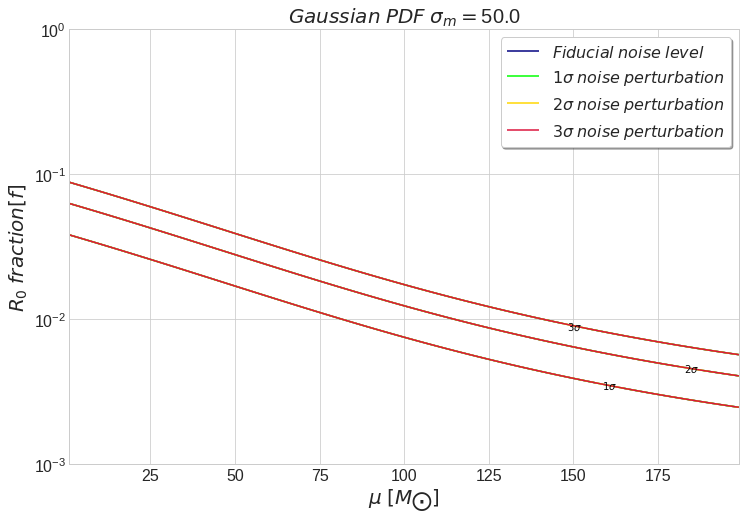

In [44]:
if PBH:
    fig, ax = plt.subplots(figsize = [12,8]) 
    contr1 = ax.contour(X, Y, Z, levels = SGWB_FidNoise[1:4], colors = 'navy')
    contr2 = ax.contour(X, Y, Z, levels = SGWB_1SigNoise[1:4], colors = 'lime')
    contr3 = ax.contour(X, Y, Z, levels = SGWB_2SigNoise[1:4], colors = 'gold')
    contr4 = ax.contour(X, Y, Z, levels = SGWB_3SigNoise[1:4], colors = 'crimson') 
    fmt = {}
    strs = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
    for l, s in zip(contr1.levels, strs):
        fmt[l] = s
    ax.clabel(contr1, inline=True, fmt = fmt, fontsize=10, colors = 'black')
    lines = [contr1.collections[0], contr2.collections[0], contr3.collections[0], contr4.collections[0]]
    labels = [r'$Fiducial \; noise \; level$', r'$1\sigma \; noise \; perturbation$', r'$2\sigma \; noise \; perturbation$', r'$3\sigma \; noise \; perturbation$']
    ax.set_ylim(1e-3,1.)
    ax.set_yscale('log')
    if PBH_Gaussian:
        ax.set_ylabel(r'$R_0 \; fraction [f]$', fontsize = 20)
        ax.set_xlabel(r'$\mu \; [M_\bigodot]$', fontsize = 20)
        ax.set_title(r'$Gaussian \; PDF \; \sigma_m = $'+str(PBH_sigmam), fontsize = 20)
        plt.legend(lines, labels, loc=1, frameon = True, fancybox = True, shadow = True)
        fig.savefig('SGWBFOMvsSigmasGSPDF.png', dpi = 500)
    if PBH_LogNormal:
        vline = ax.axvline(PBH_Mc, color = 'black')
        lines.append(vline)
        labels.append('Arxiv 2109.05836 fiducial value')
        ax.set_ylabel(r'$R_0 \; fraction [f]$', fontsize = 20)
        ax.set_xlabel(r'$M_c \; [M_\bigodot]$', fontsize = 20)
        ax.set_title(r'$LogNormal \;PDF \; \sigma_m = $'+str(PBH_sigmamn), fontsize = 20)
        plt.legend(lines, labels, loc=1, frameon = True, fancybox = True, shadow = True)
        fig.savefig('SGWBFOMvsSigmasLNPDF.png', dpi = 500)